In [3]:
from skimage.io import imread
from skimage.filters import threshold_otsu
from skimage import measure
from skimage.measure import regionprops
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import numpy as np

(480, 640)


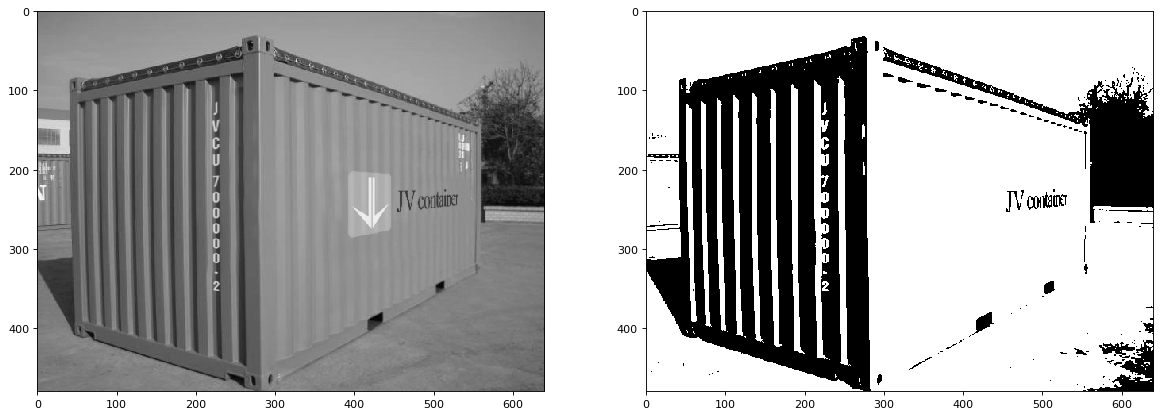

In [5]:
filename = './container1.jpg'
image = imread(filename,as_gray=True)
print(image.shape)
gray_image = image * 255
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(18, 16), dpi= 80)
ax1.imshow(gray_image, cmap="gray")
threshold_value = threshold_otsu(gray_image)
binary_image = gray_image > threshold_value
ax2.imshow(binary_image, cmap="gray")
plt.show()

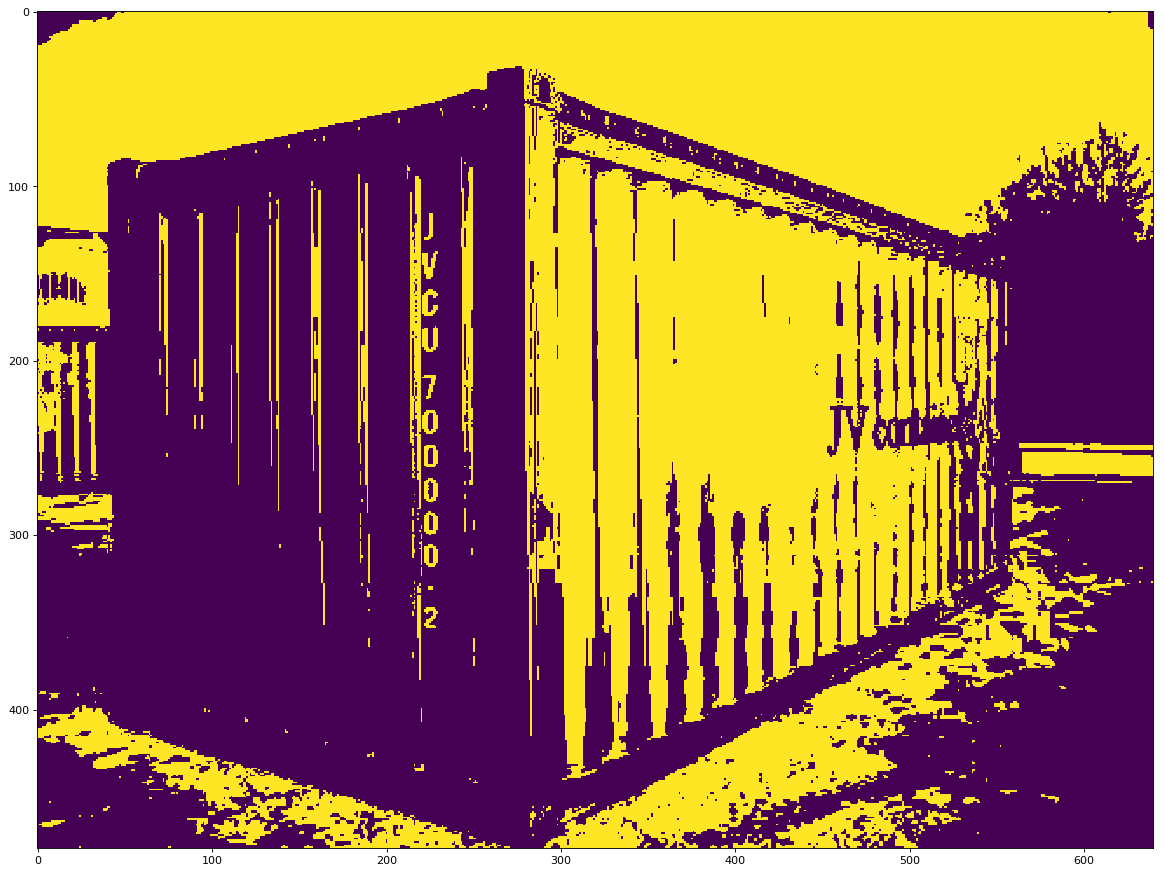

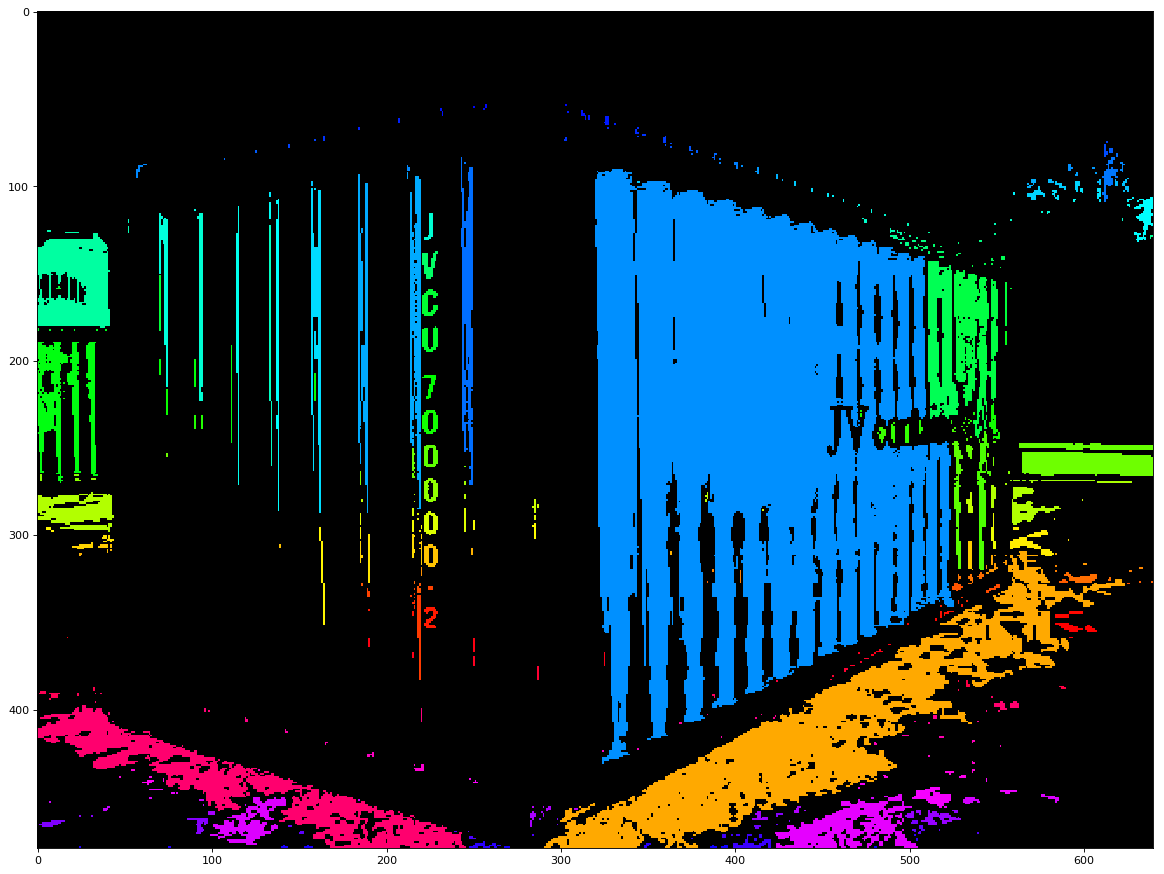

In [6]:
filename = './container1.jpg'
img = cv2.imread(filename, 0)
img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)[1]  # ensure binary
# img = cv2.bilateralFilter(img,9,75,75)
ret, labels = cv2.connectedComponents(img)
fig, (ax1) = plt.subplots(1,figsize=(18, 16), dpi= 80)
ax1.imshow(img)
def imshow_components(labels):
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0

    fig, (ax1) = plt.subplots(1,figsize=(18, 16), dpi= 80)
    ax1.imshow(labeled_img)

imshow_components(labels)

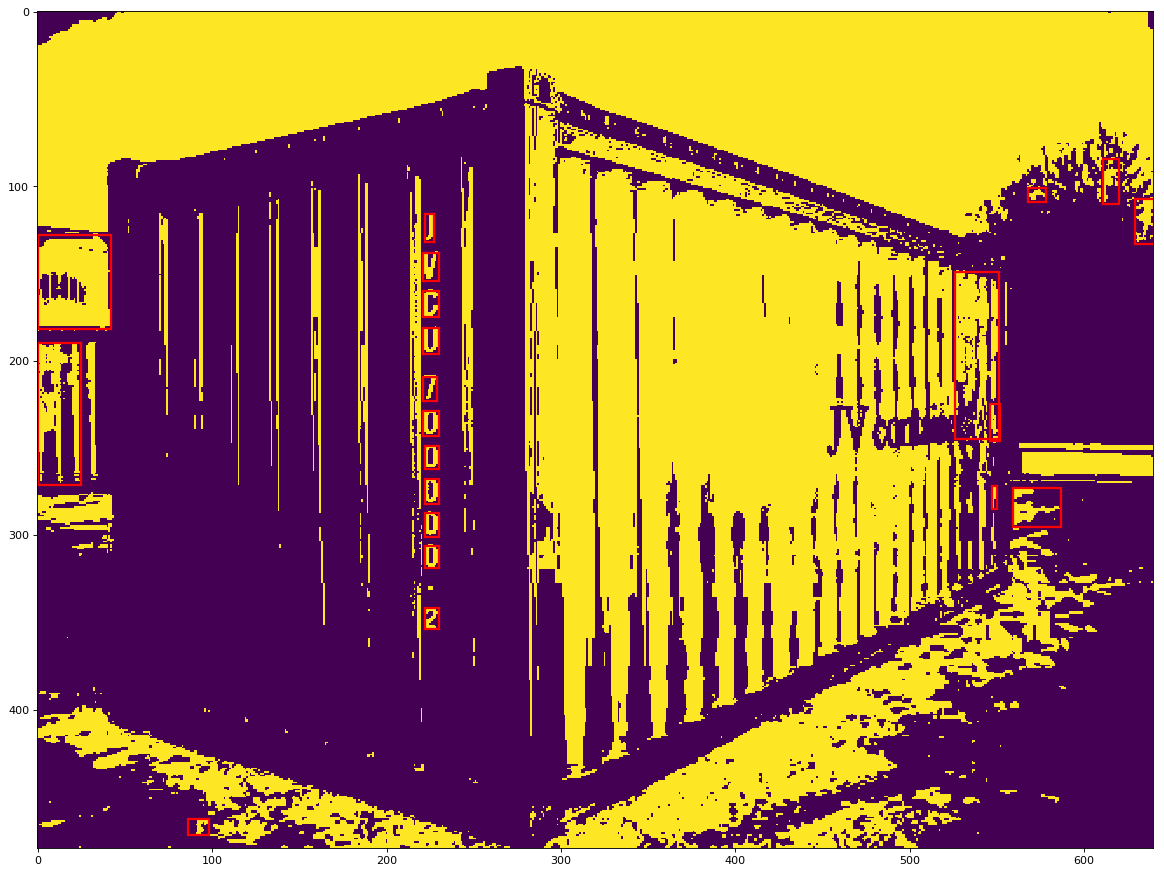

In [7]:
filename = './container1.jpg'
img = cv2.imread(filename, 0)
img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)[1]  # ensure binary
# img = cv2.bilateralFilter(img,9,75,75)
area = img.shape[0]*img.shape[1]
ret, labels = cv2.connectedComponents(img)
fig, (ax1) = plt.subplots(1,figsize=(18, 16), dpi= 80)
ax1.imshow(img)
regions=[]
centroids=[]
for region in regionprops(labels):
    min_row, min_col, max_row, max_col = region.bbox
#     print(min_row)
    region_height = max_row - min_row
    region_width = max_col - min_col
    if region.area < 30 or region.area>0.01*area:
        #if the region is so small then it's likely not a license plate
        continue
    if(region_height>0.7*region_width and region_height<5*region_width):
        
        rectBorder = patches.Rectangle((min_col, min_row), max_col - min_col, max_row - min_row, edgecolor="red",
                                           linewidth=2, fill=False)
        ax1.add_patch(rectBorder)
        regions.append(region)
        centroids.append((min_col+region_width/2,min_row+region_height/2))
    img2=img[min_row:max_row,min_col:max_col]

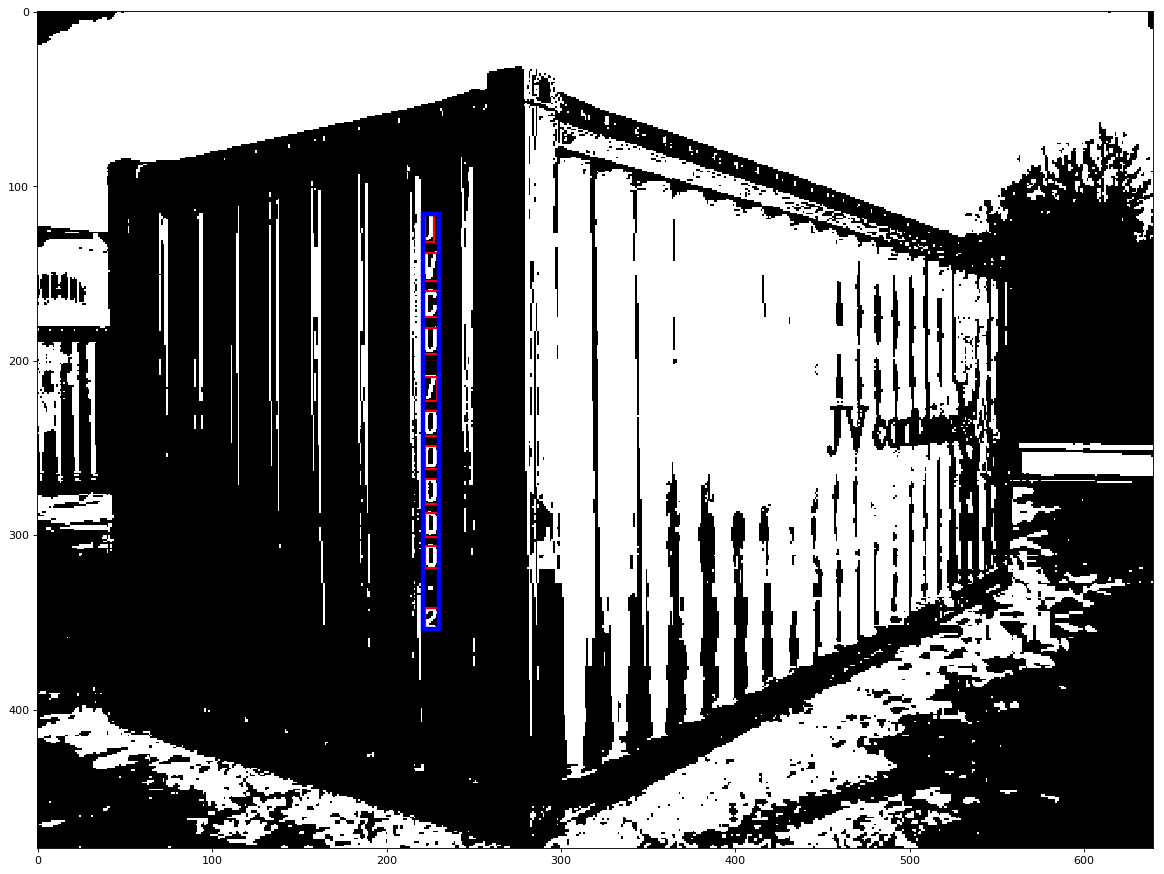

In [8]:
xs=[]
img_len=img.shape[0]
for i in range(len(regions)):
    cen1_x=centroids[i][0]
    num_vertical=0
    req_reqions=[]
    for j in range(len(regions)):
        cen2_x=centroids[j][0]
        if(abs(cen2_x-cen1_x)<0.01*img_len):
            num_vertical=num_vertical+1
            req_reqions.append(regions[j])
    if(num_vertical>5):
        break
fig, (ax1) = plt.subplots(1,figsize=(18, 16), dpi= 80)
ax1.imshow(img,cmap='gray')

bbs=[]
for region in req_reqions:
    min_row, min_col, max_row, max_col = region.bbox
    rectBorder = patches.Rectangle((min_col, min_row), max_col - min_col, max_row - min_row, edgecolor="red",
                                           linewidth=2, fill=False)
    ax1.add_patch(rectBorder)
    bbs.append(region.bbox)
# min_col=min(bbs[:][1])
import numpy as np
bbs=np.array(bbs)
min_row = min(bbs[:,0])
max_row = max(bbs[:,2])
min_col = min(bbs[:,1])
max_col = max(bbs[:,3])

rectBorder = patches.Rectangle((min_col, min_row), max_col - min_col, max_row - min_row, edgecolor="blue",
                                       linewidth=4, fill=False)
ax1.add_patch(rectBorder)

(238, 9)


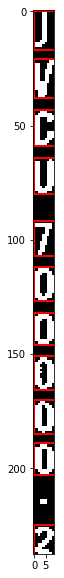

In [9]:
from skimage.transform import resize
license_plate=img[min_row:max_row,min_col:max_col]
labelled_plate = measure.label(license_plate)

fig, ax1 = plt.subplots(1,figsize=(18, 10))
ax1.imshow(license_plate, cmap="gray")
# the next two lines is based on the assumptions that the width of
# a license plate should be between 5% and 15% of the license plate,
# and height should be between 35% and 60%
# this will eliminate some
character_dimensions = (0.001*license_plate.shape[0], 0.90*license_plate.shape[0], 0.5*license_plate.shape[1], 1.1*license_plate.shape[1])
print(license_plate.shape)
min_height, max_height, min_width, max_width = character_dimensions

characters = []
counter=0
column_list = []
for regions in regionprops(labelled_plate):
    y0, x0, y1, x1 = regions.bbox
    region_height = y1 - y0
    region_width = x1 - x0

    if region_height > min_height and region_height < max_height and region_width > min_width and region_width < max_width:
        roi = license_plate[max(0,y0-1):min(y1+2,license_plate.shape[0]), 0:license_plate.shape[1]]

        # draw a red bordered rectangle over the character.
        rect_border = patches.Rectangle((0, max(0,y0-1)), license_plate.shape[1] - 0, y1 - y0+1, edgecolor="red",
                                       linewidth=2, fill=False)
        ax1.add_patch(rect_border)

        # resize the characters to 20X20 and then append each character into the characters list
        resized_char = resize(roi, (20, 20))
        # specify a threshold 0-255
        threshold = resized_char.mean()*0.5

        # make all pixels < threshold black
        resized_char = 1.0 * (resized_char < threshold)

        characters.append(resized_char)

    # this is just to keep track of the arrangement of the characters
    column_list.append(x0)
# print(characters)
plt.show()

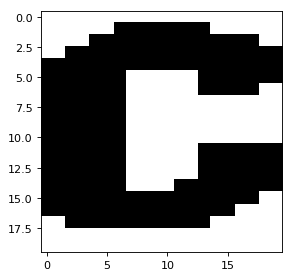

In [10]:
ig, (ax1) = plt.subplots(1,figsize=(4, 4), dpi= 80)
ax1.imshow(characters[2],cmap='gray')

In [11]:
def histogram_of_pixel_projection(img):
    """
    This method is responsible for licence plate segmentation with histogram of pixel projection approach
    :param img: input image
    :return: list of image, each one contain a digit
    """
    # list that will contains all digits
    caracrter_list_image = list()

    # img = crop(img)

    # Add black border to the image
    BLACK = [0, 0, 0]
    img = cv2.copyMakeBorder(img, 3, 3, 3, 3, cv2.BORDER_CONSTANT, value=BLACK)

    # change to gray
    gray = img

    # Change to numpy array format
    nb = np.array(gray)

    # Binarization
    nb[nb > 120] = 255
    nb[nb < 120] = 0

    # compute the sommation
    x_sum = cv2.reduce(nb, 0, cv2.REDUCE_SUM, dtype=cv2.CV_32S)
    y_sum = cv2.reduce(nb, 1, cv2.REDUCE_SUM, dtype=cv2.CV_32S)

    # rotate the vector x_sum
    x_sum = x_sum.transpose()

    # get height and weight
    x = gray.shape[1]
    y = gray.shape[0]

    # division the result by height and weight
    x_sum = x_sum / y
    y_sum = y_sum / x

    # x_arr and y_arr are two vector weight and height to plot histogram projection properly
    x_arr = np.arange(x)
    y_arr = np.arange(y)

    # convert x_sum to numpy array
    z = np.array(x_sum)

    # convert y_arr to numpy array
    w = np.array(y_sum)

    # convert to zero small details
    z[z < 15] = 0
    z[z > 15] = 1

    # convert to zero small details and 1 for needed details
    w[w < 20] = 0
    w[w > 20] = 1

    # vertical segmentation
    test = z.transpose() * nb

    # horizontal segmentation
    test = w * test

    # plot histogram projection result using pyplot
    horizontal = plt.plot(w, y_arr)
    vertical = plt.plot(x_arr ,z)

    plt.show(horizontal)
    plt.show(vertical)

    f = 0
    ff = z[0]
    t1 = list()
    t2 = list()
    for i in range(z.size):
        if z[i] != ff:
            f += 1
            ff = z[i]
            t1.append(i)
    rect_h = np.array(t1)

    f = 0
    ff = w[0]
    for i in range(w.size):
        if w[i] != ff:
            f += 1
            ff = w[i]
            t2.append(i)
    rect_v = np.array(t2)

    # take the appropriate height
    rectv = []
    rectv.append(rect_v[0])
    rectv.append(rect_v[1])
    max = int(rect_v[1]) - int(rect_v[0])
    for i in range(len(rect_v) - 1):
        diff2 = int(rect_v[i + 1]) - int(rect_v[i])

        if diff2 > max:
            rectv[0] = rect_v[i]
            rectv[1] = rect_v[i + 1]
            max = diff2

    # extract caracter
    for i in range(len(rect_h) - 1):

        # eliminate slice that can't be a digit, a digit must have width bigger then 8
        diff1 = int(rect_h[i + 1]) - int(rect_h[i])

#         if (diff1 > 5) and (z[rect_h[i]] == 1):
            # cutting nb (image) and adding each slice to the list caracrter_list_image
        caracrter_list_image.append(nb[int(rectv[0]):int(rectv[1]), rect_h[i]:rect_h[i + 1]])

        # draw rectangle on digits
        cv2.rectangle(img, (rect_h[i], rectv[0]), (rect_h[i + 1], rectv[1]), (0, 255, 0), 1)

    # Show segmentation result
    image = plt.imshow(img)
    plt.show(image)

    return caracrter_list_image

In [12]:
import pickle
print("Loading model")
filename = './finalized_model.sav'
model = pickle.load(open(filename, 'rb'))

print('Model loaded. Predicting characters of number plate')
classification_result = []
for each_character in characters:
    # converts it to a 1D array
    each_character = each_character.reshape(1, -1);
    result = model.predict(each_character)
    classification_result.append(result)

print('Classification result')
print(classification_result)

plate_string = ''
for eachPredict in classification_result:
    plate_string += eachPredict[0]

print('Predicted license plate')
print(plate_string)

# it's possible the characters are wrongly arranged
# since that's a possibility, the column_list will be
# used to sort the letters in the right order

# column_list_copy = SegmentCharacters.column_list[:]
# SegmentCharacters.column_list.sort()
# rightplate_string = ''
# for each in SegmentCharacters.column_list:
#     rightplate_string += plate_string[column_list_copy.index(each)]

# print('License plate')
# print(rightplate_string)

Loading model
Model loaded. Predicting characters of number plate
Classification result
[array(['U'], dtype='<U1'), array(['D'], dtype='<U1'), array(['1'], dtype='<U1'), array(['1'], dtype='<U1'), array(['D'], dtype='<U1'), array(['Z'], dtype='<U1'), array(['1'], dtype='<U1'), array(['Z'], dtype='<U1'), array(['Z'], dtype='<U1'), array(['Z'], dtype='<U1'), array(['H'], dtype='<U1')]
Predicted license plate
UD11DZ1ZZZH
